# Efficiency losses for compute repricings

## Using empirical data from 7904

#### Maria Silva, November 2025

In [1]:
import os
import duckdb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

## Load and process data

In [3]:
# Main directories
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")

First, let's load the empirical data from EIP-7904. This data was taken directly from the [EIP's additional files](https://github.com/ethereum/EIPs/blob/master/assets/eip-7904/final_gas_schedule_comparison.csv).

In [4]:
df = pd.read_csv(os.path.join(data_dir, "final_gas_schedule_comparison.csv"))
df = df.drop(columns=["ethereumjs_gas", "ethereumjs_gas_stderr", "evmone_gas", "evmone_gas_stderr"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   besu_gas                    167 non-null    float64
 1   besu_gas_stderr             167 non-null    float64
 2   erigon_gas                  166 non-null    float64
 3   erigon_gas_stderr           166 non-null    float64
 4   geth_gas                    166 non-null    float64
 5   geth_gas_stderr             166 non-null    float64
 6   nethermind_gas              166 non-null    float64
 7   nethermind_gas_stderr       166 non-null    float64
 8   revm_gas                    154 non-null    float64
 9   revm_gas_stderr             154 non-null    float64
 10  opcode                      167 non-null    object 
 11  constant_current_gas        167 non-null    float64
 12  alternative_gas             167 non-null    float64
 13  alternative_gas_stderr      167 non

In [5]:
client_gas_cols = [c for c in df.columns[:9] if c.endswith("_gas")]
worse_df = df.copy()
# Get slowest value across clients 
worse_df["param_ns"] = df[client_gas_cols].max(axis=1)
# Select columns
worse_df = worse_df[["opcode", "param_ns", "constant_current_gas"]]
# Exclude zeros, logs and ARG2s from the analysis
worse_df = worse_df[worse_df["constant_current_gas"]>0]
worse_df = worse_df[~worse_df["opcode"].str.startswith("LOG")]
worse_df = worse_df[~worse_df["opcode"].str.endswith("ARG2")]
# Fix some opcode names
worse_df["opcode"] = np.where(worse_df["opcode"].str.endswith("ARG1"), worse_df["opcode"].str[:-5], worse_df["opcode"])

worse_df

,opcode,param_ns,constant_current_gas
0,ADD,7.171282,3.000
1,MUL,8.143532,5.000
2,SUB,6.806273,3.000
3,DIV,5.826503,5.000
4,SDIV,9.435828,5.000
...,...,...,...
152,TSTORE_EXT,92.914882,100.000
153,EXP,45.865094,50.000
154,KECCAK256,1.920549,6.000
165,RIPEMD-160,1.683618,3.750


## Compute efficiency losses for 500M gas limit @4s execution time

In [6]:
limit = 500*1e6
ex_time = 5*1e9
params_df = worse_df.copy()
# current
params_df["op_per_time"] = np.floor(ex_time/params_df["param_ns"]).astype(int)
params_df["op_per_limit_current"] = np.floor(limit/params_df["constant_current_gas"]).astype(int)
params_df["eff_loss_current"] = (params_df["op_per_time"]/params_df["op_per_limit_current"])-1
# new gas rounded
params_df["new_gas_rounded"] = np.ceil((limit*params_df["param_ns"])/ex_time).astype(int)
params_df["op_per_limit_rounded"] = np.floor(limit/params_df["new_gas_rounded"]).astype(int)
params_df["eff_loss_rounded"] = (params_df["op_per_time"]/params_df["op_per_limit_rounded"])-1
# new gas fractional
params_df["new_gas_frac"] = np.ceil(100*(limit*params_df["param_ns"])/ex_time)/100
params_df["op_per_limit_frac"] = np.floor(limit/params_df["new_gas_frac"]).astype(int)
params_df["eff_loss_frac"] = (params_df["op_per_time"]/params_df["op_per_limit_frac"])-1
# new gas minimal
params_df["new_gas_minimal"] = np.ceil((limit*params_df["param_ns"])/ex_time).astype(int)
params_df["new_gas_minimal"] = np.where(
    params_df["new_gas_minimal"]>params_df["constant_current_gas"], 
    params_df["new_gas_minimal"], 
    params_df["constant_current_gas"]
    )
params_df["op_per_limit_minimal"] = np.floor(limit/params_df["new_gas_minimal"]).astype(int)
params_df["eff_loss_minimal"] = (params_df["op_per_time"]/params_df["op_per_limit_minimal"])-1

params_df

,opcode,param_ns,constant_current_gas,op_per_time,op_per_limit_current,eff_loss_current,new_gas_rounded,op_per_limit_rounded,eff_loss_rounded,new_gas_frac,op_per_limit_frac,eff_loss_frac,new_gas_minimal,op_per_limit_minimal,eff_loss_minimal
0,ADD,7.171282,3.000,697225406,166666666,3.183352,1,500000000,0.394451,0.72,694444444,0.004005,3.00,166666666,3.183352
1,MUL,8.143532,5.000,613984221,100000000,5.139842,1,500000000,0.227968,0.82,609756097,0.006934,5.00,100000000,5.139842
2,SUB,6.806273,3.000,734616438,166666666,3.407699,1,500000000,0.469233,0.69,724637681,0.013771,3.00,166666666,3.407699
3,DIV,5.826503,5.000,858147725,100000000,7.581477,1,500000000,0.716295,0.59,847457627,0.012614,5.00,100000000,7.581477
4,SDIV,9.435828,5.000,529895205,100000000,4.298952,1,500000000,0.059790,0.95,526315789,0.006801,5.00,100000000,4.298952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,TSTORE_EXT,92.914882,100.000,53812692,5000000,9.762538,10,50000000,0.076254,9.30,53763440,0.000916,100.00,5000000,9.762538
153,EXP,45.865094,50.000,109015365,10000000,9.901537,5,100000000,0.090154,4.59,108932461,0.000761,50.00,10000000,9.901537
154,KECCAK256,1.920549,6.000,2603421591,83333333,30.241059,1,500000000,4.206843,0.20,2500000000,0.041369,6.00,83333333,30.241059
165,RIPEMD-160,1.683618,3.750,2969794772,133333333,21.273461,1,500000000,4.939590,0.17,2941176470,0.009730,3.75,133333333,21.273461


In [7]:
params_df[params_df["new_gas_minimal"]>params_df["constant_current_gas"]]

,opcode,param_ns,constant_current_gas,op_per_time,op_per_limit_current,eff_loss_current,new_gas_rounded,op_per_limit_rounded,eff_loss_rounded,new_gas_frac,op_per_limit_frac,eff_loss_frac,new_gas_minimal,op_per_limit_minimal,eff_loss_minimal
141,ECADD,3642.884099,250.000,1372538,2000000,-0.313731,365,1369863,0.001953,364.29,1372532,0.000004,365.0,1369863,0.001953
166,SHA2-256,0.764516,0.375,6540087356,1333333333,3.905066,1,500000000,12.080175,0.08,6250000000,0.046414,1.0,500000000,12.080175


In [8]:
print("Number of repriced opcodes:")
print("Minimal repricing:", sum(params_df["new_gas_minimal"]!=params_df["constant_current_gas"]))
print("Rounded repricing:", sum(params_df["new_gas_rounded"]!=params_df["constant_current_gas"]))
print("Fractional repricing:", sum(params_df["new_gas_frac"]!=params_df["constant_current_gas"]))

Number of repriced opcodes:
Minimal repricing: 2
Rounded repricing: 148
Fractional repricing: 151


## Efficiency losses per opcode

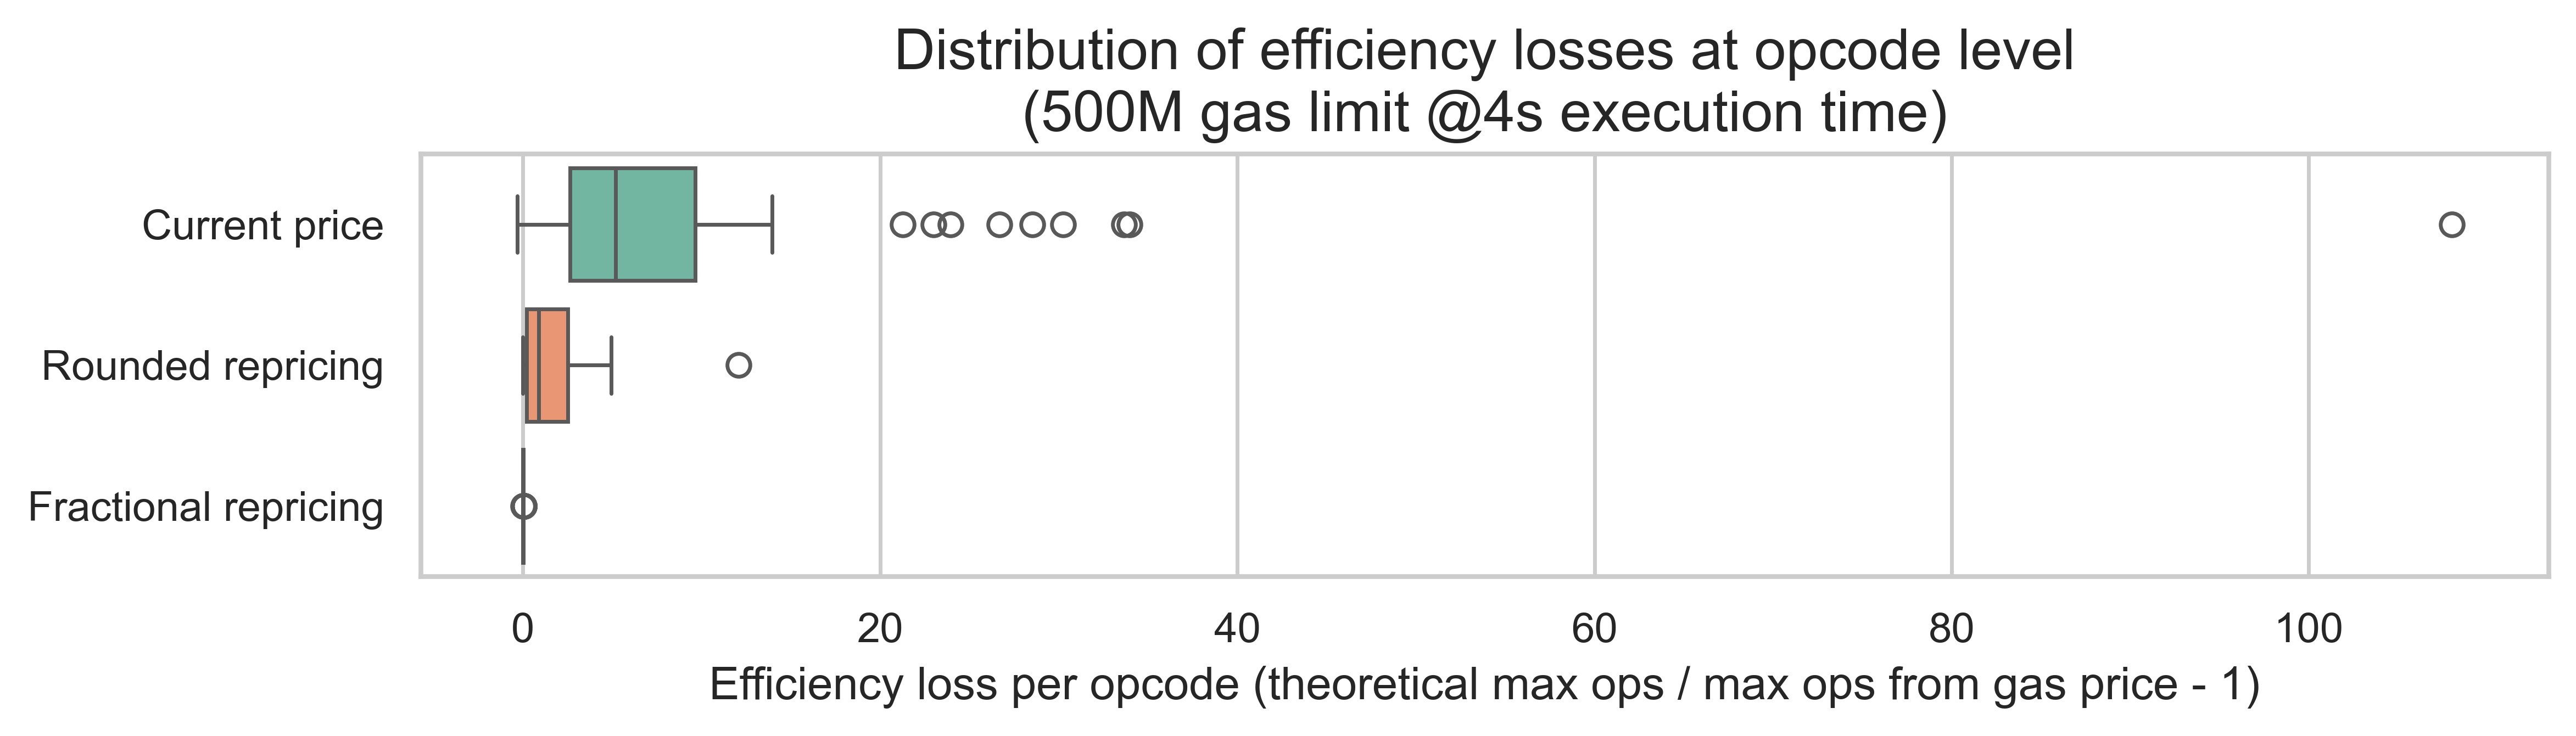

In [9]:
eff_loss_df = params_df[
    [
        "opcode",
        "eff_loss_current",
        "eff_loss_rounded",
        "eff_loss_frac",
    ]
]
eff_cols = ["Current price", "Rounded repricing", "Fractional repricing"]
eff_loss_df.columns = ["opcode"] + eff_cols
eff_loss_df = eff_loss_df.melt(
    id_vars=["opcode"],
    value_vars=eff_cols,
    var_name="repricing_strategy",
    value_name="efficiency_loss",
)

plt.figure(figsize=(10, 2))
sns.boxplot(
    data=eff_loss_df,
    x="efficiency_loss",
    y="repricing_strategy",
    hue="repricing_strategy",
    legend=False
)
plt.title("Distribution of efficiency losses at opcode level\n(500M gas limit @4s execution time)")
plt.ylabel("")
plt.xlabel("Efficiency loss per opcode (theoretical max ops / max ops from gas price - 1)")
plt.show()

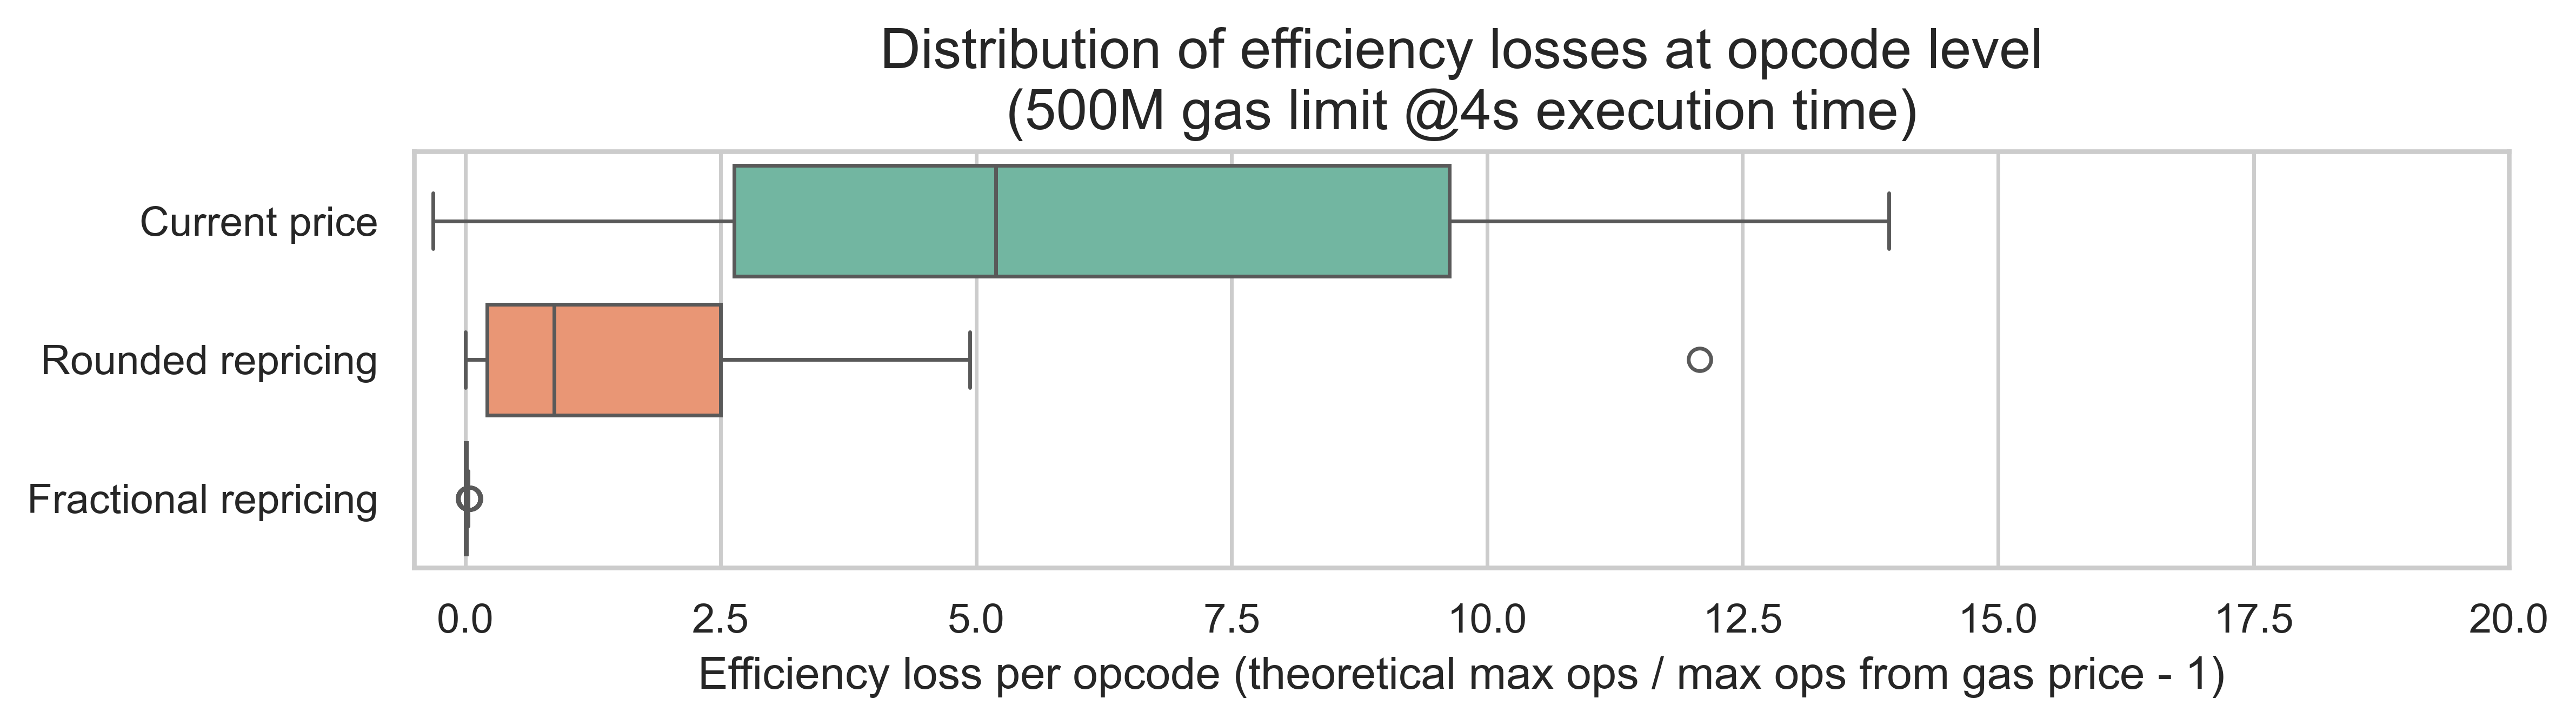

In [10]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=eff_loss_df,
    x="efficiency_loss",
    y="repricing_strategy",
    hue="repricing_strategy",
    legend=False
)
plt.xlim(-0.5,20)
plt.title("Distribution of efficiency losses at opcode level\n(500M gas limit @4s execution time)")
plt.ylabel("")
plt.xlabel("Efficiency loss per opcode (theoretical max ops / max ops from gas price - 1)")
plt.show()

## Efficiency losses per transaction

First, we need to load the transactions traces

In [11]:
block_start = 22000000
block_end = 22001000
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_v3", "*", "file.parquet")
# Load parquet files with duckdb
query = f"""
SELECT 
    block_height,
    tx_hash,
    op AS opcode,
    op_gas_cost,
    op_gas_pair_count,
    call_address
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    union_by_name=True
    )
WHERE block_height BETWEEN {block_start} AND {block_end};
"""
raw_agg_trace_df = duckdb.connect().execute(query).fetchdf()
# Print info
raw_agg_trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12934668 entries, 0 to 12934667
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_height       int64  
 1   tx_hash            object 
 2   opcode             object 
 3   op_gas_cost        float64
 4   op_gas_pair_count  int64  
 5   call_address       object 
dtypes: float64(1), int64(2), object(3)
memory usage: 592.1+ MB


Now we need to process the traces to isolate the costs of precompiles. We first define some auxiliary functions and then process the data.

In [12]:
PRECOMPILE_MAP = {
    1: {"name": "ECRECOVER", "fixed_cost": 3000.0},
    2: {"name": "SHA2-256", "fixed_cost": 60.0},
    3: {"name": "RIPEMD-160", "fixed_cost": 600.0},
    4: {"name": "IDENTITY", "fixed_cost": 15.0},
    5: {"name": "MODEXP", "fixed_cost": 200.0},
    6: {"name": "ECADD", "fixed_cost": 150.0},
    7: {"name": "ECMUL", "fixed_cost": 6000.0},
    8: {"name": "ECPAIRING317000", "fixed_cost": 45000.0}, # assuming worse case!
    9: {"name": "BLAKE2F", "fixed_cost": 0.0},
    10: {"name": "point_evaluation", "fixed_cost": 50000.0},
}

def is_precompile(call_address: str) -> bool:
    try:
        call_address_int = int(call_address, 16)
        if call_address_int in PRECOMPILE_MAP.keys():
            return True
        else:
            return False
    except:
        return False


def map_precompile(call_address: str) -> int | None:
    if is_precompile(call_address):
        call_address_int = int(call_address, 16)
        precompile = PRECOMPILE_MAP.get(call_address_int).get("name")
    else:
        precompile = None
    return precompile


def map_precompile_fixed_cost(call_address: str) -> float:
    if is_precompile(call_address):
        call_address_int = int(call_address, 16)
        cost = PRECOMPILE_MAP.get(call_address_int).get("fixed_cost")
    else:
        cost = 0.0
    return cost

In [13]:
agg_trace_df = raw_agg_trace_df.copy()
# Fix create2
agg_trace_df["opcode"] = np.where(agg_trace_df["opcode"]=="CREATE2", "CREATE", agg_trace_df["opcode"])
# Fix precompiles
agg_trace_df["precomp_name"] = agg_trace_df["call_address"].apply(
    lambda x: map_precompile(x)
)
agg_trace_df["precomp_cost"] = (
    agg_trace_df["call_address"].apply(lambda x: map_precompile_fixed_cost(x)).fillna(0)
)
agg_trace_df["op_gas_cost"] = agg_trace_df["op_gas_cost"] - agg_trace_df["precomp_cost"]
precomp_df = agg_trace_df[agg_trace_df["precomp_name"].notna()]
precomp_df["opcode"] = precomp_df["precomp_name"]
precomp_df["op_gas_cost"] = precomp_df["precomp_cost"]
agg_trace_df = pd.concat([agg_trace_df, precomp_df], ignore_index=True).drop(
    columns=["precomp_name", "precomp_cost", "call_address"]
)
agg_trace_df.head()

,block_height,tx_hash,opcode,op_gas_cost,op_gas_pair_count
0,22000000,0x02dba2a7974424be6778984c2f5594189af0d7b42bc5...,ADD,3.0,287
1,22000000,0x02dba2a7974424be6778984c2f5594189af0d7b42bc5...,ADDRESS,2.0,4
2,22000000,0x02dba2a7974424be6778984c2f5594189af0d7b42bc5...,AND,3.0,241
3,22000000,0x02dba2a7974424be6778984c2f5594189af0d7b42bc5...,CALL,100.0,1
4,22000000,0x02dba2a7974424be6778984c2f5594189af0d7b42bc5...,CALL,100.0,1


Now we can join the traces with the opcode repricing data to compute efficiency losses per transaction.

In [14]:
# Let see which opcodes will be ignored
cols = ["param_ns", "new_gas_minimal", "new_gas_rounded", "new_gas_frac"]
tx_params_df = agg_trace_df.merge(params_df[["opcode"] + cols], on="opcode", how="left")
tx_params_df[tx_params_df["param_ns"].isna()]["opcode"].unique()

array(['LOG1', 'LOG3', 'RETURN', 'SLOAD', 'SSTORE', 'STOP', 'LOG2',
       'BLOBHASH', 'BLOCKHASH', 'LOG4', 'REVERT', 'BASEFEE', 'BALANCE',
       'BLOBBASEFEE', 'LOG0', 'INVALID', 'SELFDESTRUCT',
       'point_evaluation'], dtype=object)

In [15]:
# Join gas costs with transaction traces
cols = ["param_ns", "new_gas_minimal", "new_gas_rounded", "new_gas_frac"]
tx_params_df = agg_trace_df.merge(params_df[["opcode"] + cols], on="opcode", how="left")
tx_params_df["param_ns"] = tx_params_df["param_ns"].fillna(
    tx_params_df["op_gas_cost"] * ex_time / limit
)
tx_params_df["new_gas_minimal"] = tx_params_df["new_gas_minimal"].fillna(
    tx_params_df["op_gas_cost"]
)
tx_params_df["new_gas_rounded"] = tx_params_df["new_gas_rounded"].fillna(
    tx_params_df["op_gas_cost"]
)
tx_params_df["new_gas_frac"] = tx_params_df["new_gas_frac"].fillna(
    tx_params_df["op_gas_cost"]
)
# Compute total cost per transaction
tx_params_df[cols + ["op_gas_cost"]] = tx_params_df[cols + ["op_gas_cost"]].mul(
    tx_params_df["op_gas_pair_count"], axis=0
)
tx_params_df = (
    tx_params_df.groupby(["tx_hash"])[cols + ["op_gas_cost"]].sum().reset_index()
)
tx_params_df["new_gas_frac"] = np.ceil(tx_params_df["new_gas_frac"])
# cleanup column names
tx_params_df.columns = [
    "tx_hash",
    "total_ex_time_ns",
    "total_gas_minimal",
    "total_gas_rounded",
    "total_gas_frac",
    "total_gas_current",
]
# Compute efficiency metrics
tx_params_df["tx_per_time"] = np.floor(ex_time / tx_params_df["total_ex_time_ns"])
tx_params_df["tx_per_limit_current"] = np.floor(limit/tx_params_df["total_gas_current"])
tx_params_df["tx_per_limit_minimal"] = np.floor(limit/tx_params_df["total_gas_minimal"])
tx_params_df["tx_per_limit_rounded"] = np.floor(limit/tx_params_df["total_gas_rounded"])
tx_params_df["tx_per_limit_frac"] = np.floor(limit/tx_params_df["total_gas_frac"])
tx_params_df["eff_loss_current"] = (tx_params_df["tx_per_time"]/tx_params_df["tx_per_limit_current"])-1
tx_params_df["eff_loss_minimal"] = (tx_params_df["tx_per_time"]/tx_params_df["tx_per_limit_minimal"])-1
tx_params_df["eff_loss_rounded"] = (tx_params_df["tx_per_time"]/tx_params_df["tx_per_limit_rounded"])-1
tx_params_df["eff_loss_frac"] = (tx_params_df["tx_per_time"]/tx_params_df["tx_per_limit_frac"])-1

tx_params_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84976 entries, 0 to 84975
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tx_hash               84976 non-null  object 
 1   total_ex_time_ns      84976 non-null  float64
 2   total_gas_minimal     84976 non-null  float64
 3   total_gas_rounded     84976 non-null  float64
 4   total_gas_frac        84976 non-null  float64
 5   total_gas_current     84976 non-null  float64
 6   tx_per_time           84976 non-null  float64
 7   tx_per_limit_current  84976 non-null  float64
 8   tx_per_limit_minimal  84976 non-null  float64
 9   tx_per_limit_rounded  84976 non-null  float64
 10  tx_per_limit_frac     84976 non-null  float64
 11  eff_loss_current      84976 non-null  float64
 12  eff_loss_minimal      84976 non-null  float64
 13  eff_loss_rounded      84976 non-null  float64
 14  eff_loss_frac         84976 non-null  float64
dtypes: float64(14), obj

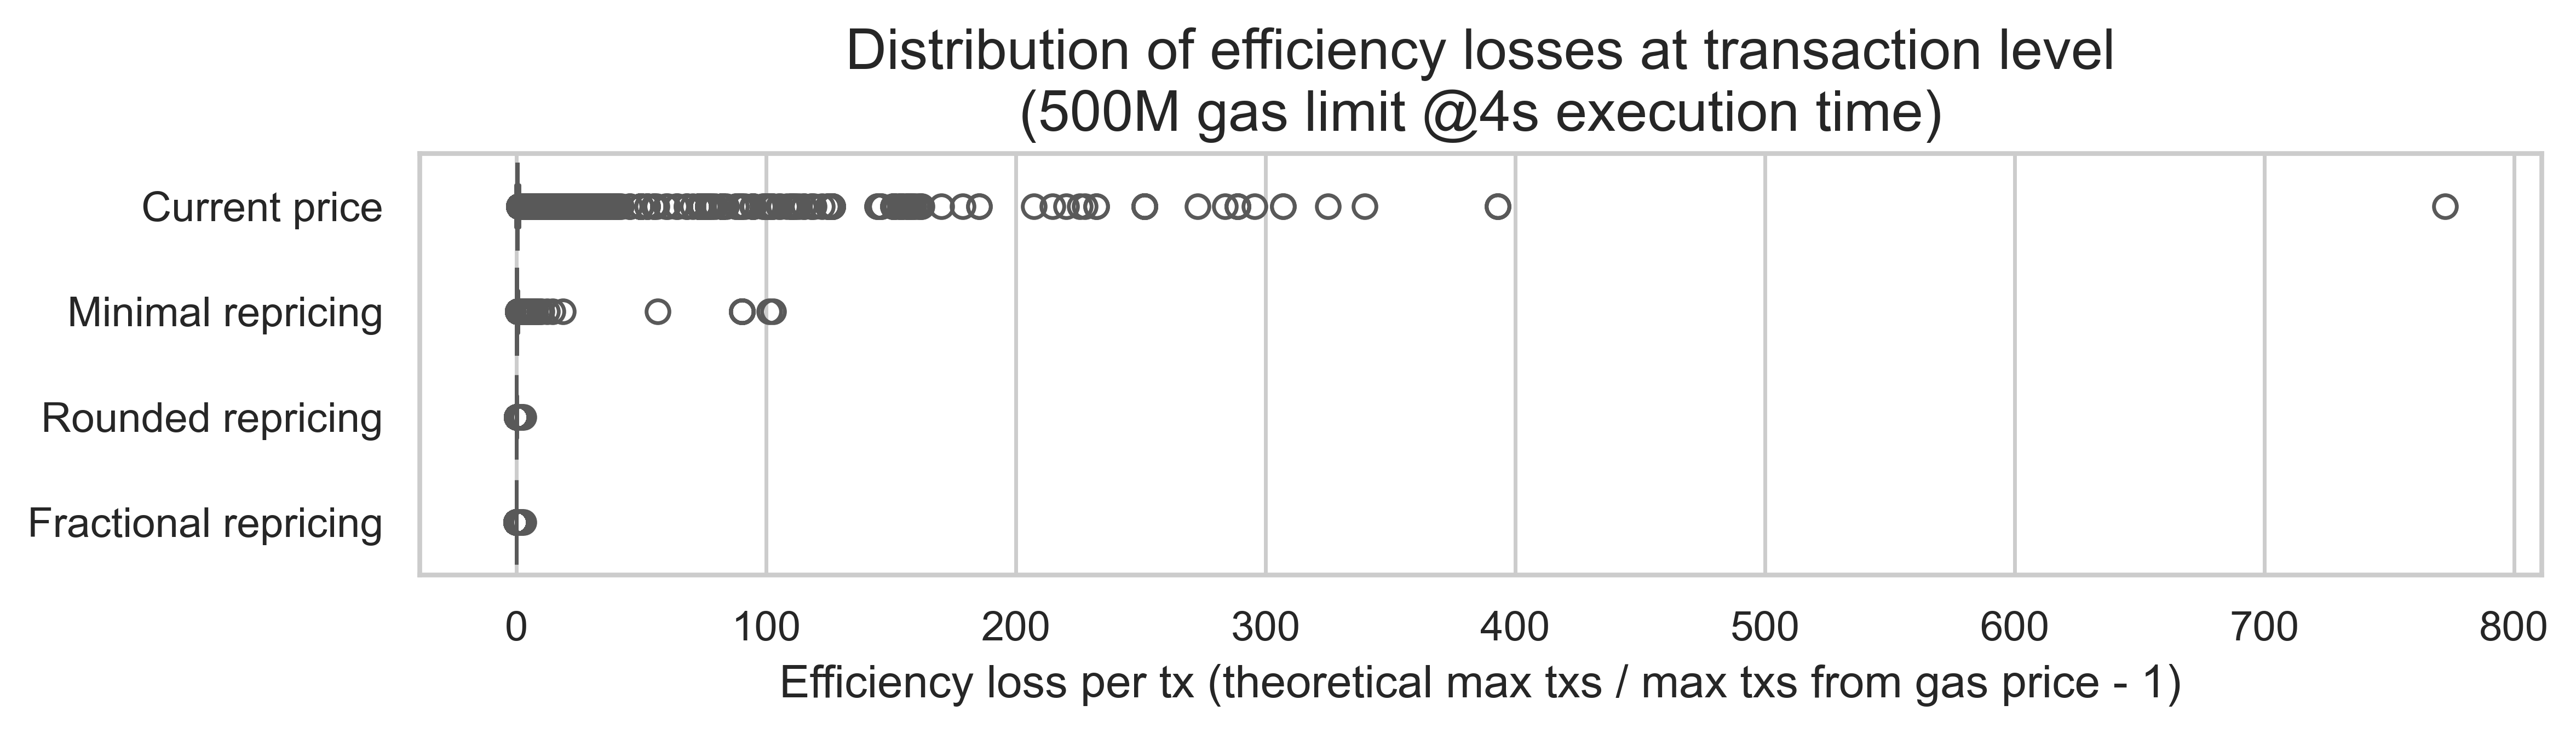

In [16]:
tx_eff_loss_df = tx_params_df[
    [
        "tx_hash",
        "eff_loss_current",
        "eff_loss_minimal",
        "eff_loss_rounded",
        "eff_loss_frac",
    ]
]
eff_cols = ["Current price", "Minimal repricing", "Rounded repricing", "Fractional repricing"]
tx_eff_loss_df.columns = ["tx_hash"] + eff_cols
tx_eff_loss_df = tx_eff_loss_df.melt(
    id_vars=["tx_hash"],
    value_vars=eff_cols,
    var_name="repricing_strategy",
    value_name="efficiency_loss",
)

plt.figure(figsize=(10, 2))
sns.boxplot(
    data=tx_eff_loss_df,
    x="efficiency_loss",
    y="repricing_strategy",
    hue="repricing_strategy",
    legend=False
)
plt.title("Distribution of efficiency losses at transaction level\n(500M gas limit @4s execution time)")
plt.ylabel("")
plt.xlabel("Efficiency loss per tx (theoretical max txs / max txs from gas price - 1)")
plt.show()

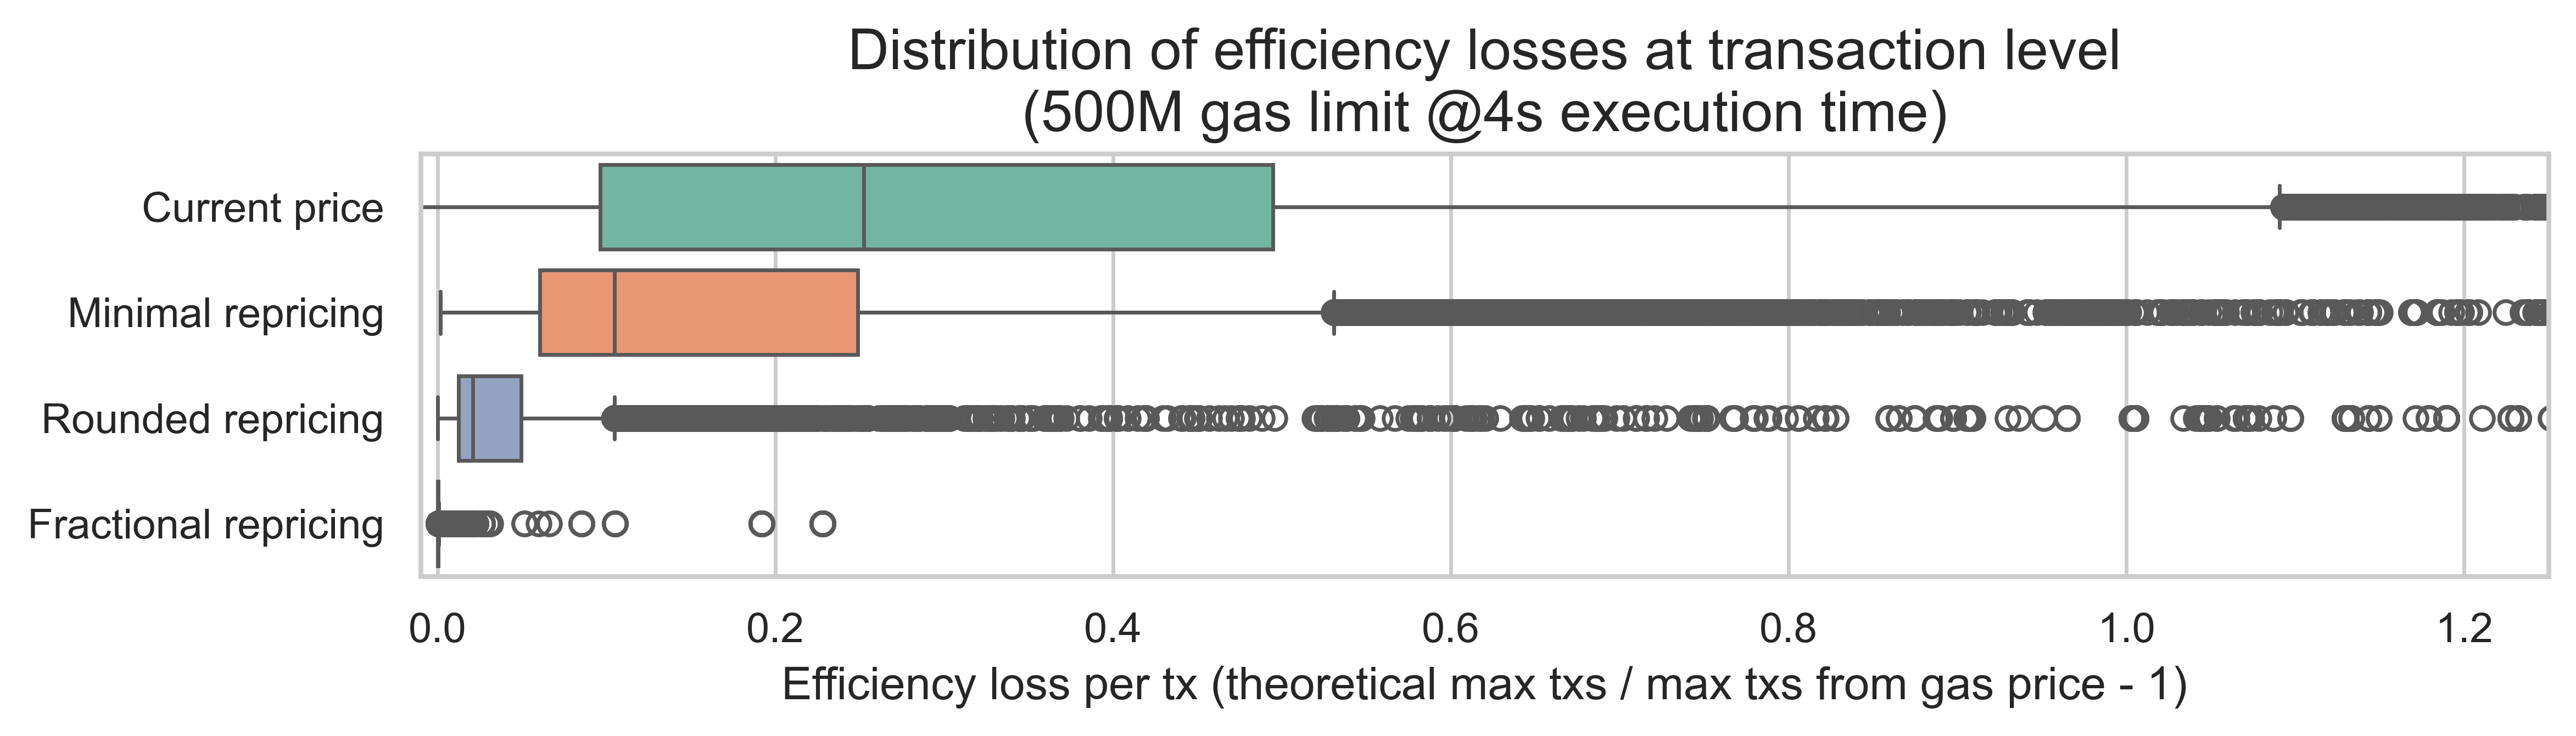

In [17]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=tx_eff_loss_df,
    x="efficiency_loss",
    y="repricing_strategy",
    hue="repricing_strategy",
    legend=False
)
plt.xlim(-0.01,1.25)
plt.title("Distribution of efficiency losses at transaction level\n(500M gas limit @4s execution time)")
plt.ylabel("")
plt.xlabel("Efficiency loss per tx (theoretical max txs / max txs from gas price - 1)")
plt.show()

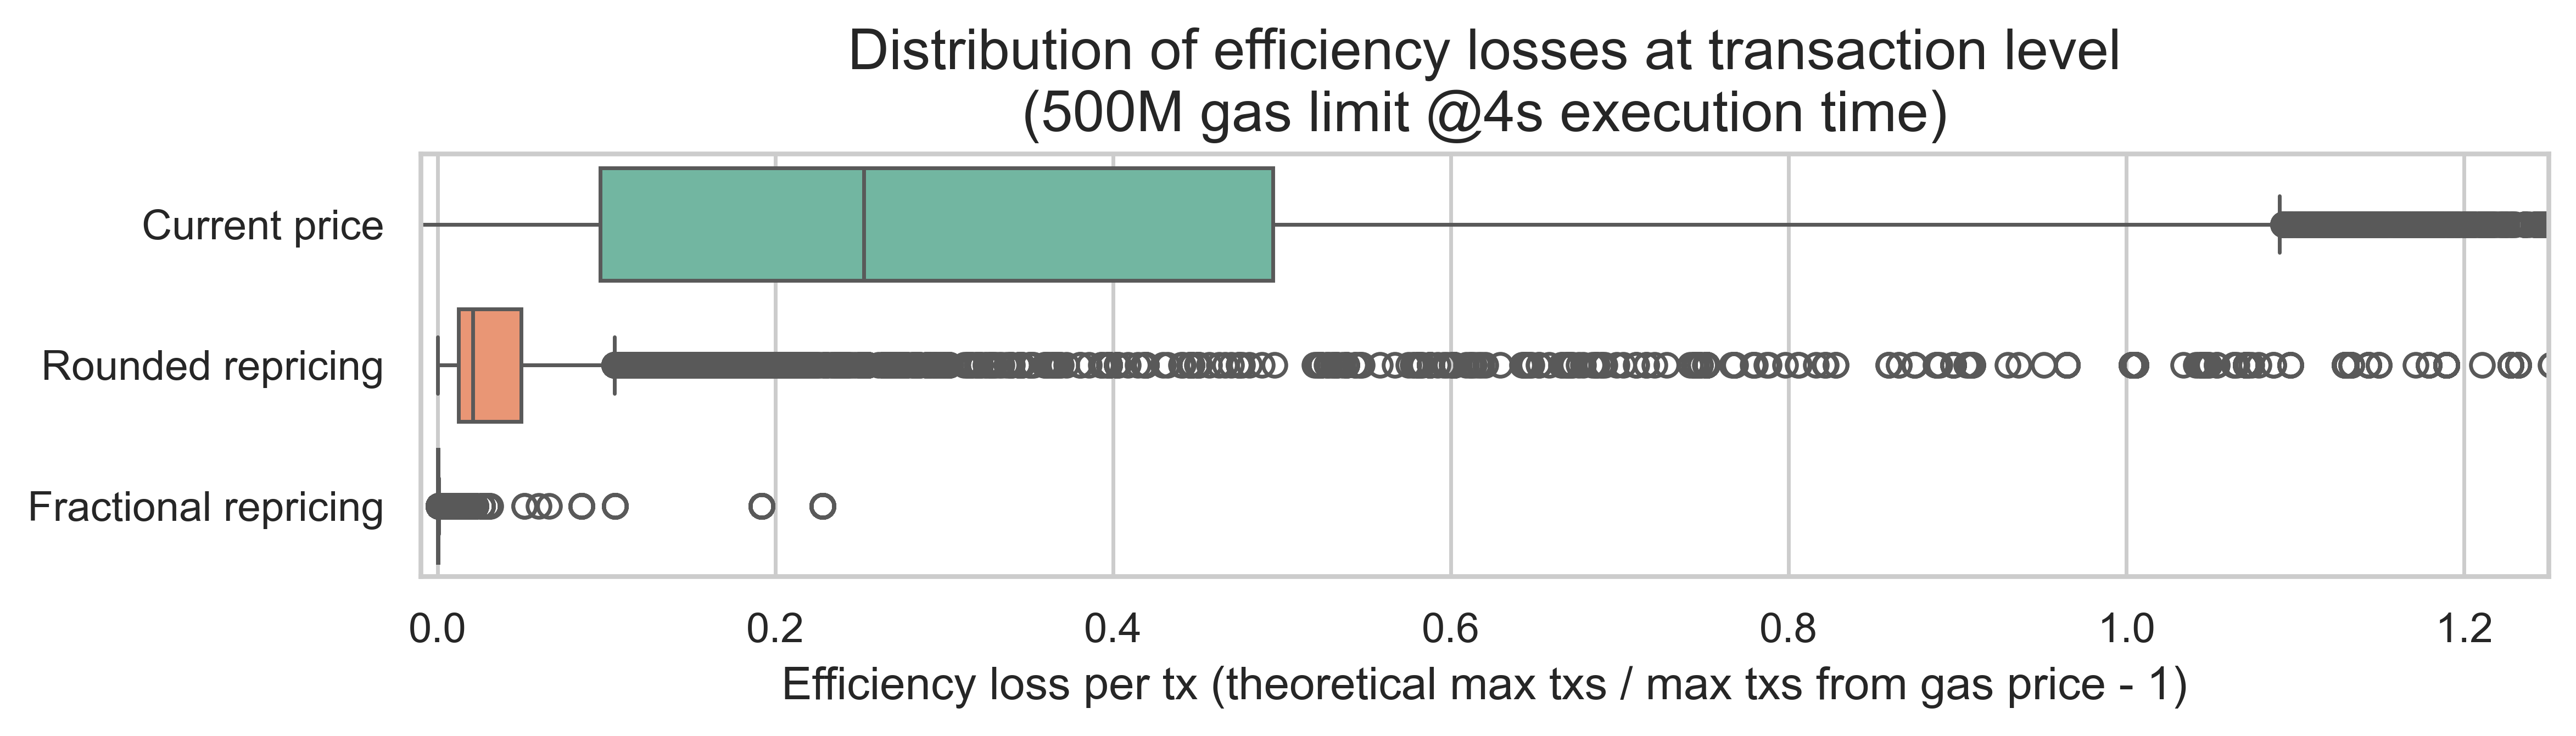

In [18]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=tx_eff_loss_df[tx_eff_loss_df["repricing_strategy"]!="Minimal repricing"],
    x="efficiency_loss",
    y="repricing_strategy",
    hue="repricing_strategy",
    legend=False
)
plt.xlim(-0.01,1.25)
plt.title("Distribution of efficiency losses at transaction level\n(500M gas limit @4s execution time)")
plt.ylabel("")
plt.xlabel("Efficiency loss per tx (theoretical max txs / max txs from gas price - 1)")
plt.show()

In [19]:
tx_eff_loss_df[tx_eff_loss_df["efficiency_loss"] > 1.25].groupby("repricing_strategy").size()

repricing_strategy
Current price           3388
Fractional repricing       6
Minimal repricing       1382
Rounded repricing        308
dtype: int64

In [20]:
tx_eff_loss_df[tx_eff_loss_df["efficiency_loss"] > 1.25].groupby(
    "repricing_strategy"
).size() / tx_eff_loss_df.groupby("repricing_strategy").size().iloc[0]

repricing_strategy
Current price           0.039870
Fractional repricing    0.000071
Minimal repricing       0.016263
Rounded repricing       0.003625
dtype: float64